# **ICE: Multiple Regression Analysis**
## Name: Cabot Steward
## *DATA 3300*

In this ICE, we will examine a dataset on exercise routines and their impact on weight change. The steps will include preprocessing the data, categorizeing exercise routines into different groups, and removing multicollinear features using the Variance Inflation Factor (VIF). Then, a multiple linear regression model is will be built to predict weight change based on various predictors. The model's performance will then be assessed through summary statistics, and diagnostic plots such as Residuals vs Fitted and Normal Q-Q plots to check the assumptions of linearity and normality of residuals.

> ### **Business Scenario**

> Consider a fitness company that offers personalized training programs to its clients. The company wants to optimize its exercise routines to achieve the best weight loss results for its customers. By conducting a regression analysis on the data collected from various exercise routines and their effects on weight change, the company can identify which routines are most effective. This information will enable the company to tailor their programs to individual clients based on their exercise preferences and health metrics, ultimately improving client satisfaction and retention by providing data-driven, effective workout plans.

> ### **Data Card**

* ID: Identifier for each entry
* Exercise: Type of exercise performed
* Calories Burn: Average Calories burned during the exercise
* Dream Weight: The weight the individual aims for
* Starter Weight: The individual's starting weight at time of joining gym
* Age: Age of the individual
* Gender: Gender of the individual
* Duration: Average Duration of the exercise in minutes
* Heart Rate: Average Heart rate during the exercise
* BMI: Body Mass Index at time of joining gym
* Weather Conditions: Most common Weather during the exercise
* Exercise Intensity: Average Intensity of the exercise
* Weight Change: Change in weight after 2 months at gym

Let's begin by loading the dataset and the dependencies...

In [1]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
df = pd.read_csv('updated_exercise_dataset.csv')
# produce heading
df.head()

,ID,Exercise,Calories Burn,Dream Weight,Starter Weight,Age,Gender,Duration,Heart Rate,BMI,Weather Conditions,Exercise Intensity,Weight Change
0,1,Exercise 2,286.959851,91.892531,96.301115,45,Male,37,170,29.426275,Rainy,5,0.496714
1,2,Exercise 7,343.453036,64.165097,61.104668,25,Male,43,142,21.286346,Rainy,5,-0.138264
2,3,Exercise 4,261.223465,70.846224,71.766724,20,Male,20,148,27.899592,Cloudy,4,0.647689
3,4,Exercise 5,127.183858,79.477008,82.984456,33,Male,39,170,33.729552,Sunny,10,-1.291041
4,5,Exercise 10,416.318374,89.960226,85.643174,29,Female,34,118,23.286113,Cloudy,3,-0.234153


## 1)
**Let's do a bit of data preprocessing and first check for any missing values.**

In [4]:
# check for missing data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3864 entries, 0 to 3863
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  3864 non-null   int64  
 1   Exercise            3864 non-null   object 
 2   Calories Burn       3864 non-null   float64
 3   Dream Weight        3864 non-null   float64
 4   Starter Weight      3864 non-null   float64
 5   Age                 3864 non-null   int64  
 6   Gender              3864 non-null   object 
 7   Duration            3864 non-null   int64  
 8   Heart Rate          3864 non-null   int64  
 9   BMI                 3864 non-null   float64
 10  Weather Conditions  3864 non-null   object 
 11  Exercise Intensity  3864 non-null   int64  
 12  Weight Change       3864 non-null   float64
dtypes: float64(5), int64(5), object(3)
memory usage: 392.6+ KB


### A)
**There are quite a few different types of exercises (1-10), and since they are categorical, would lead to having many dummy variables. How could we reduce down Exercise type to a smaller number of categories?**

Identify a smaller subset of metrics needed.

In [5]:
df.groupby('Exercise')['Calories Burn'].mean() # view means for Exercise on another variable

Exercise
Exercise 1     290.644109
Exercise 10    294.298761
Exercise 2     300.101287
Exercise 3     295.770273
Exercise 4     315.026142
Exercise 5     305.357542
Exercise 6     302.971544
Exercise 7     307.585135
Exercise 8     301.700059
Exercise 9     305.971948
Name: Calories Burn, dtype: float64

In [6]:
# relabel the values Exercise to routines 1-3

df['Exercise'] = df['Exercise'].replace(['Exercise 1', 'Exercise 10', 'Exercise 3'], 'routine 1')
df['Exercise'] = df['Exercise'].replace(['Exercise 2', 'Exercise 6', 'Exercise 5', 'Exercise 9', 'Exercise 8'], 'routine 2')
df['Exercise'] = df['Exercise'].replace(['Exercise 7', 'Exercise 4'], 'routine 3')
df.head()

,ID,Exercise,Calories Burn,Dream Weight,Starter Weight,Age,Gender,Duration,Heart Rate,BMI,Weather Conditions,Exercise Intensity,Weight Change
0,1,routine 2,286.959851,91.892531,96.301115,45,Male,37,170,29.426275,Rainy,5,0.496714
1,2,routine 3,343.453036,64.165097,61.104668,25,Male,43,142,21.286346,Rainy,5,-0.138264
2,3,routine 3,261.223465,70.846224,71.766724,20,Male,20,148,27.899592,Cloudy,4,0.647689
3,4,routine 2,127.183858,79.477008,82.984456,33,Male,39,170,33.729552,Sunny,10,-1.291041
4,5,routine 1,416.318374,89.960226,85.643174,29,Female,34,118,23.286113,Cloudy,3,-0.234153


In [7]:
# check all have been assigned
df['Exercise'].value_counts()

Exercise
routine 2    1921
routine 1    1186
routine 3     757
Name: count, dtype: int64

### B)
**Next, let set up our set of IVs (X) and DV (Y). What should be removed from X and what do we set as Y?**

we should remove the primary key and DV from Y, we set Y as weight change because that's our target variable

In [11]:
X = df.drop(['ID', 'Weight Change'], axis = 1)
X = pd.get_dummies(X, drop_first=True, dtype='int')
y = df['Weight Change']

X.head()

,Calories Burn,Dream Weight,Starter Weight,Age,Duration,Heart Rate,BMI,Exercise Intensity,Exercise_routine 2,Exercise_routine 3,Gender_Male,Weather Conditions_Rainy,Weather Conditions_Sunny
0,286.959851,91.892531,96.301115,45,37,170,29.426275,5,1,0,1,1,0
1,343.453036,64.165097,61.104668,25,43,142,21.286346,5,0,1,1,1,0
2,261.223465,70.846224,71.766724,20,20,148,27.899592,4,0,1,1,0,0
3,127.183858,79.477008,82.984456,33,39,170,33.729552,10,1,0,1,0,1
4,416.318374,89.960226,85.643174,29,34,118,23.286113,3,0,0,0,0,0


### C)
**Finally, let's check to see if any variables need to be further removed from X by checking each variable's VIF value. What assumption does this evaluate?**

This is checking for multicollinearity to see if all our IVs are indepdent of eachother.

### D)

**How do we proceed with variables whose VIF values exceed the threshold (in this case VIF = 10)?**

Systematically remove them one at a time, starting with highest value, don't drop all at once.

In [12]:
vif = pd.DataFrame()
vif['features'] = X.columns
vif['vif_value'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# print vif
print(vif)

                    features   vif_value
0              Calories Burn    7.431153
1               Dream Weight  749.059403
2             Starter Weight  724.043055
3                        Age   10.146172
4                   Duration   11.788294
5                 Heart Rate   26.638499
6                        BMI   25.366683
7         Exercise Intensity    4.538176
8         Exercise_routine 2    2.606345
9         Exercise_routine 3    1.643429
10               Gender_Male    1.960550
11  Weather Conditions_Rainy    1.954514
12  Weather Conditions_Sunny    1.914176


In [13]:
X.drop('Dream Weight', axis = 1, inplace=True) # drop first var

In [14]:
vif = pd.DataFrame()
vif['features'] = X.columns
vif['vif_value'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif)

                    features  vif_value
0              Calories Burn   7.424976
1             Starter Weight  21.565138
2                        Age  10.131348
3                   Duration  11.788103
4                 Heart Rate  26.581779
5                        BMI  25.234619
6         Exercise Intensity   4.534832
7         Exercise_routine 2   2.604910
8         Exercise_routine 3   1.643403
9                Gender_Male   1.960549
10  Weather Conditions_Rainy   1.954170
11  Weather Conditions_Sunny   1.914152


In [15]:
X.drop('Heart Rate', axis = 1, inplace=True) # drop next var

In [16]:
vif = pd.DataFrame()
vif['features'] = X.columns
vif['vif_value'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif)

                    features  vif_value
0              Calories Burn   7.347042
1             Starter Weight  19.644806
2                        Age   9.827567
3                   Duration  11.362022
4                        BMI  21.944695
5         Exercise Intensity   4.486148
6         Exercise_routine 2   2.596540
7         Exercise_routine 3   1.639824
8                Gender_Male   1.945143
9   Weather Conditions_Rainy   1.947385
10  Weather Conditions_Sunny   1.906057


In [17]:
X.drop('BMI', axis = 1, inplace=True) # drop third var

In [18]:
vif = pd.DataFrame()
vif['features'] = X.columns
vif['vif_value'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif)

                   features  vif_value
0             Calories Burn   7.065241
1            Starter Weight  16.204277
2                       Age   9.242829
3                  Duration  10.536692
4        Exercise Intensity   4.423200
5        Exercise_routine 2   2.565386
6        Exercise_routine 3   1.628287
7               Gender_Male   1.928229
8  Weather Conditions_Rainy   1.933759
9  Weather Conditions_Sunny   1.890851


In [19]:
X.drop('Starter Weight', axis = 1, inplace=True) # drop fourth var

In [20]:
vif = pd.DataFrame()
vif['features'] = X.columns
vif['vif_value'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif)

                   features  vif_value
0             Calories Burn   6.517296
1                       Age   8.052130
2                  Duration   8.907669
3        Exercise Intensity   4.266473
4        Exercise_routine 2   2.509947
5        Exercise_routine 3   1.618369
6               Gender_Male   1.907247
7  Weather Conditions_Rainy   1.893803
8  Weather Conditions_Sunny   1.851558


## 2)
**Run a multiple regression analysis, then print the summary statistics.**

In [22]:
X = sm.add_constant(X) # add constant
model = sm.OLS(y, X).fit()# fit model
# print summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          Weight Change   R-squared:                       0.239
Model:                            OLS   Adj. R-squared:                  0.238
Method:                 Least Squares   F-statistic:                     134.8
Date:                Thu, 17 Apr 2025   Prob (F-statistic):          1.58e-221
Time:                        10:52:54   Log-Likelihood:                -7425.5
No. Observations:                3864   AIC:                         1.487e+04
Df Residuals:                    3854   BIC:                         1.493e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

### A)
**Which, if any variables are not statistically significant (alpha = 0.1), how do you know this?**

exercise routine type is not significant becuase neighter 2 or 3 have a significant difference in wieghted average. 

### B)

**What is the R-squared value and what does it mean?**

R-Squared is ~0.24 meaning about 24% variance in weight can be changed explained by our regression model

### C)
**What's at least one other variable our clients don't have access to that likely has some explanatory power in weight change? What impact would adding that variable (if we had access to it) have on the R-squared?**

one additional variable that could further explain weight change, is diet.  If we had access to that data it would likely increase our R-Squared giving us further insight

## 3)
**Create the final model by dropping the NS variable(s), then produce diagnostic plots to check whether any further assumptions are being violated:**

In [23]:
X.drop(['Exercise_routine 2', 'Exercise_routine 3'], axis = 1, inplace = True)
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          Weight Change   R-squared:                       0.239
Model:                            OLS   Adj. R-squared:                  0.238
Method:                 Least Squares   F-statistic:                     173.4
Date:                Thu, 17 Apr 2025   Prob (F-statistic):          9.52e-224
Time:                        10:58:23   Log-Likelihood:                -7425.6
No. Observations:                3864   AIC:                         1.487e+04
Df Residuals:                    3856   BIC:                         1.492e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

### A)
**What, if any impact, did dropping the NS variables have on the R-squared value?**

Removal of these variables did not impact R-Squared

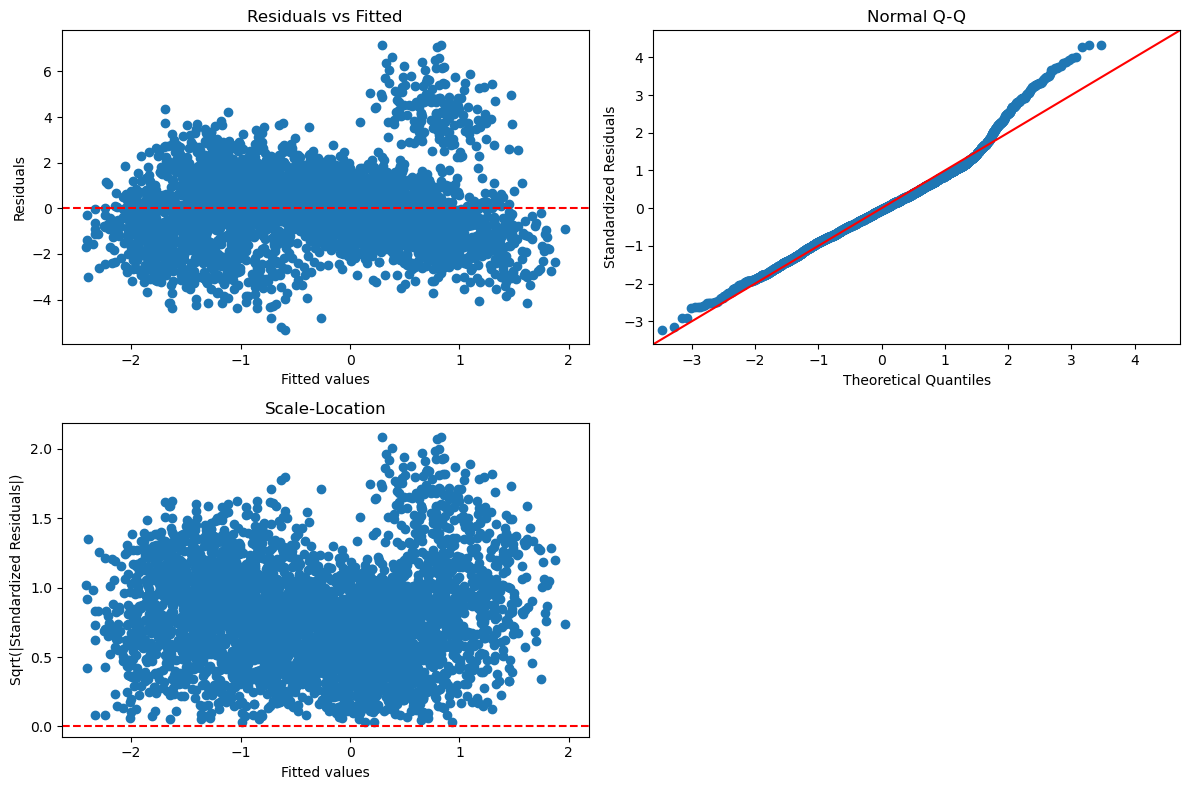

In [24]:
# Residuals vs Fitted
fitted_values = model.fittedvalues # store fitted values
residuals = model.resid # store residuals
standardized_residuals = model.get_influence().resid_studentized_internal

plt.figure(figsize=(12, 8))

# Residuals vs Fitted Plot
plt.subplot(2, 2, 1)
plt.scatter(fitted_values, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted')

# Q-Q Plot
plt.subplot(2, 2, 2)
sm.qqplot(standardized_residuals, line='45', ax=plt.gca())
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Standardized Residuals')
plt.title('Normal Q-Q')

# Scale-Location Plot
plt.subplot(2, 2, 3)
plt.scatter(fitted_values, np.sqrt(np.abs(standardized_residuals)))
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Fitted values')
plt.ylabel('Sqrt(|Standardized Residuals|)')
plt.title('Scale-Location')

plt.tight_layout()
plt.show()

### B)

**Describe which assumption each of the above visuals pertains to, and comment on whether that assumption appears to be violated.**

* **Residuals vs Fitted**: Linearity and Homoscedasticity (constant variance). - The plot shows a clear funnel shape, indicating heteroscedasticity, so the assumption of constant variance is violated.
* **Noraml Q-Q**: Normality of residuals - The residuals deviate from the red line at both tails, indicating that the residuals are not normally distributed, so the assumption is violated
* **Scale-Location**: Homoscedasticity (equal variance of residuals across fitted values) - The spread increases at the ends, which suggests non-constant variance, so the assumption is violated.

### C)
**What data visualization(s) can we use to check for outliers as well as non-normal distribution of variables?**

box plots, histograms, q-q plots, scatterplots of residuals

### D)

**First check the X variables, and transform as necessary. Do the variables in this case appear to contain outliers or to be non-normally distributed?**

In [25]:
# check columns in X
X.columns

Index(['const', 'Calories Burn', 'Age', 'Duration', 'Exercise Intensity',
       'Gender_Male', 'Weather Conditions_Rainy', 'Weather Conditions_Sunny'],
      dtype='object')

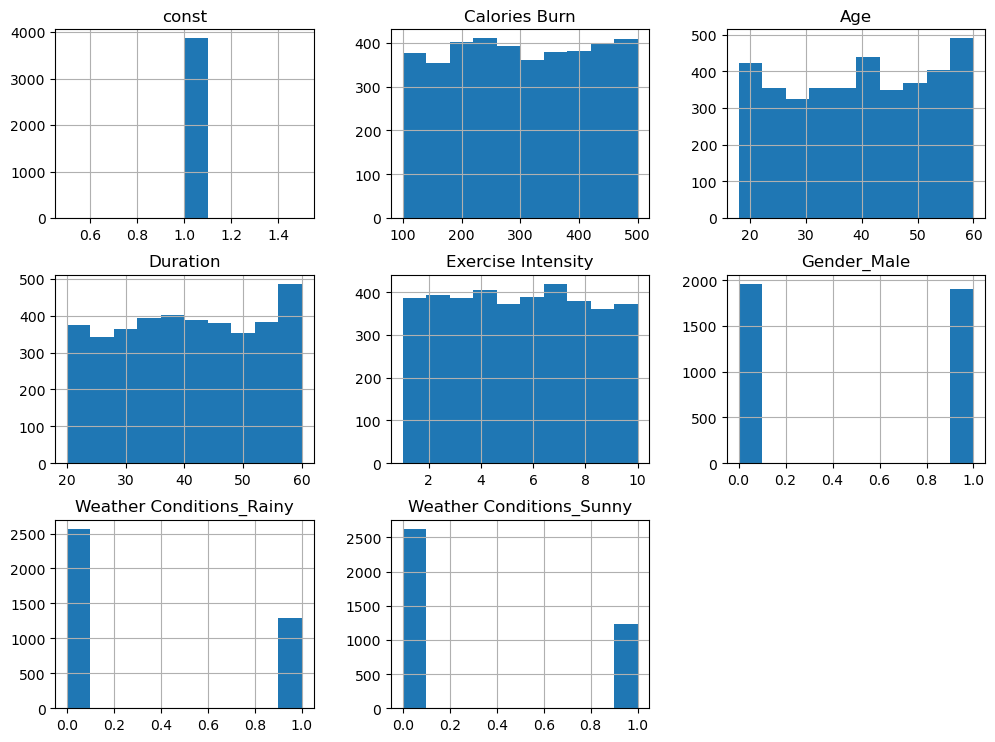

In [28]:
X.hist(layout=(4,3), figsize=(12,12))
plt.show()

In [29]:
X_log = X.copy() # create a copy of X

# Log transform variables with positive values and no zeros
# create new Exercise Intensity var by log transforming
X_log['Exercise Intensity'] = np.log(X['Exercise Intensity'])
X_log['Calories Burn'] = np.log(X['Calories Burn'])
X_log['Age'] = np.log(X['Age'])
X_log['Duration'] = np.log(X['Duration'])

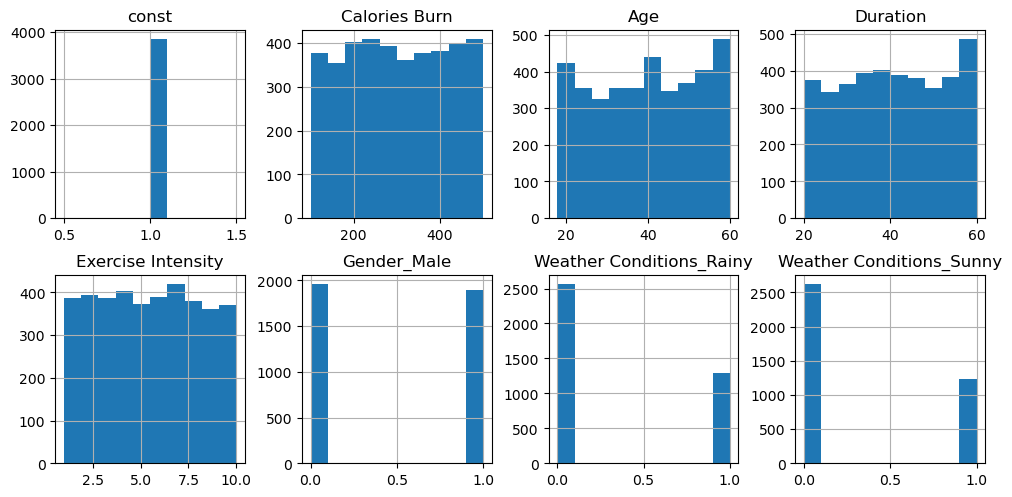

In [30]:
X.hist(layout=(4,4), figsize=(12,12)) # display new vars
plt.show()

### E)
**How would you describe the distribution of Y?**

<Axes: >

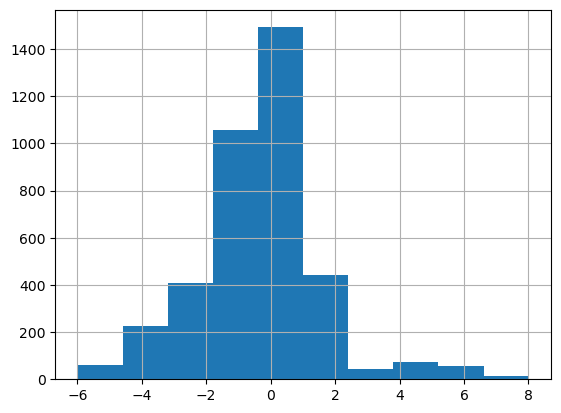

In [31]:
# display hist of y
y.hist()

<Axes: >

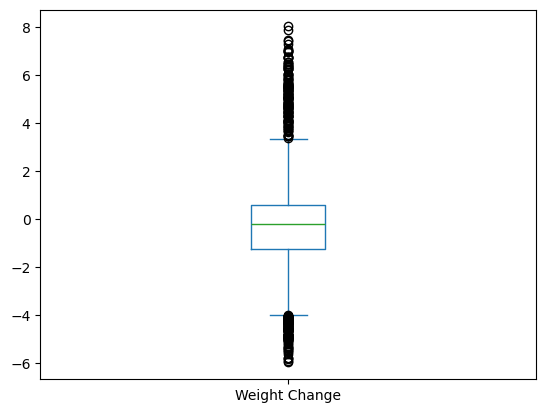

In [32]:
# Check for outliers
y.plot(kind='box')

### F)

**What kind of transformation can we do to y to make the distribution more normal (and also reduce the number of outliers)?**

<Axes: >

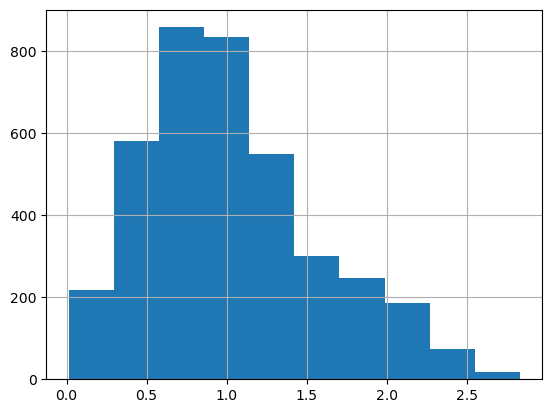

In [33]:
# take the absolute value of y then do a sqrt transformation
y_transformed = np.sqrt(np.abs(y))

# Plot the transformed data
y_transformed.hist()

## 4)
**Rerun the regression with your transformed variable(s). Did transforming X make the distributions normal? How about for Y?**

y improved, x didnt normalize enough

In [34]:
model_T = sm.OLS(y_transformed, X).fit()
print(model_T.summary())

                            OLS Regression Results                            
Dep. Variable:          Weight Change   R-squared:                       0.214
Model:                            OLS   Adj. R-squared:                  0.213
Method:                 Least Squares   F-statistic:                     150.0
Date:                Thu, 17 Apr 2025   Prob (F-statistic):          2.08e-196
Time:                        11:10:58   Log-Likelihood:                -2630.5
No. Observations:                3864   AIC:                             5277.
Df Residuals:                    3856   BIC:                             5327.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

### A)

**What impact did transforming Y have on the model and residuals?**

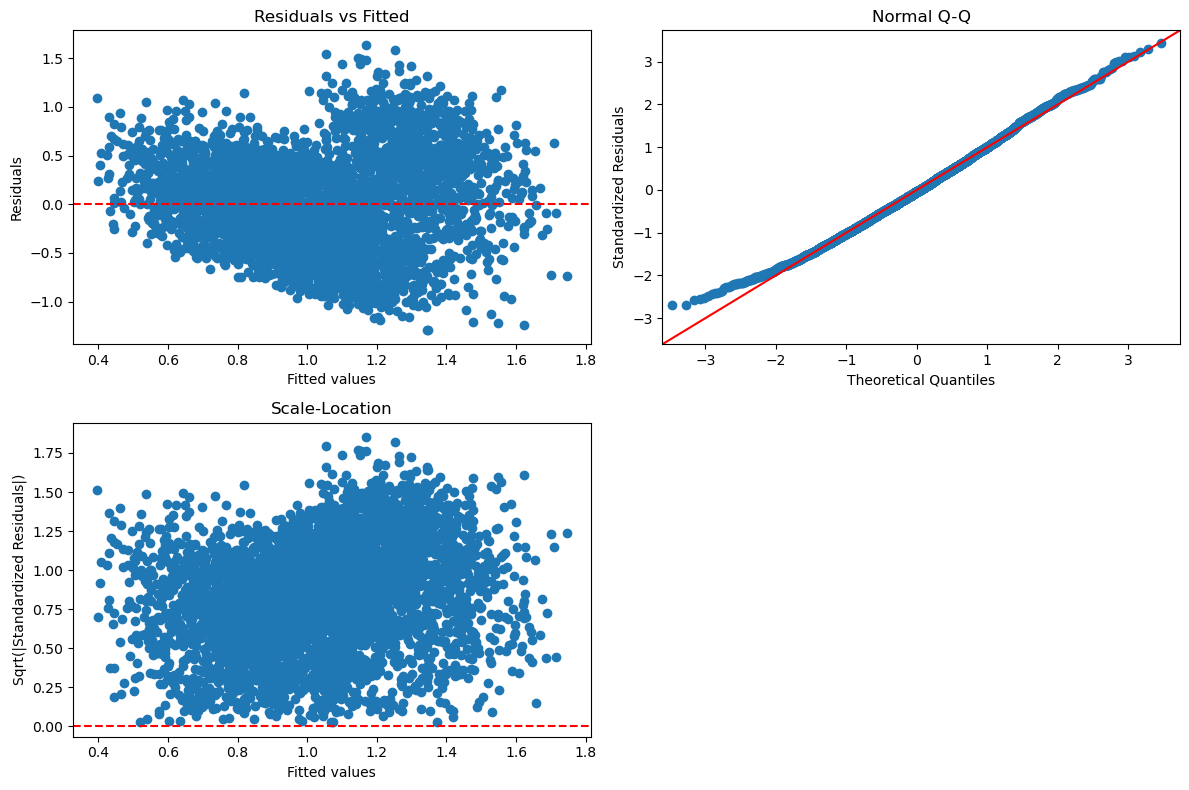

In [35]:
# Residuals vs Fitted
fitted_values = model_T.fittedvalues
residuals = model_T.resid
standardized_residuals = model_T.get_influence().resid_studentized_internal

plt.figure(figsize=(12, 8))

# Residuals vs Fitted Plot
plt.subplot(2, 2, 1)
plt.scatter(fitted_values, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted')

# Q-Q Plot
plt.subplot(2, 2, 2)
sm.qqplot(standardized_residuals, line='45', ax=plt.gca())
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Standardized Residuals')
plt.title('Normal Q-Q')

# Scale-Location Plot
plt.subplot(2, 2, 3)
plt.scatter(fitted_values, np.sqrt(np.abs(standardized_residuals)))
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Fitted values')
plt.ylabel('Sqrt(|Standardized Residuals|)')
plt.title('Scale-Location')

plt.tight_layout()
plt.show()

### B)
**What impact does transforming the variables have on the interpretation of the regression equation?**

the plots are looking better.  which means we can trust the results of the model a little more.

### C)
**How would you interpret the slope of `Calories Burn`?**

for each calorie burned there is an associated 0.0004 ^2 lb increase in weight.

### D)

**Is there a significant difference in weight change on sunny days as compared to cloudy? How about rainy? What is the average difference?**

THere is a difference in weight between sunny and cloudy days but not cloudy and rainy days 

### E)

**Based on the model findings, what recommendations can you make to our client in terms of which variables they're collecting should be focused on in maximizing weight change, and which are less critical? What other data could they asked gym members to provide to improve their model performance?**

The best time to lose weight in during sunny days, I would ask additional information about calorie intake to dictake performance improvement potential.
